In [21]:

import torch
from torch.distributions.multivariate_normal import MultivariateNormal
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim
import matplotlib.pyplot as plt

In [10]:
"""
Idea: Want a clean theoretical example where overtraining can increase lipschitz constants. 
      Let's consider linear classifiers trying to minimize squared loss/XE loss over a simple gaussian dataset:
      0-labels drawn from N(-1, std_0), 1-labels drawn from N(+1, std_1)
"""



d0 = MultivariateNormal(-2 * torch.ones(3), torch.eye(3))    
d1 = MultivariateNormal(2 * torch.ones(3), torch.eye(3))    

In [11]:
# Build datasets 
def train_data(num_mbs=16, mb_size=128):
    mbs = [] 
    sub_mb = mb_size // 2
    for mb in range(num_mbs):
        data_0 = d0.sample((sub_mb,))
        data_1 = d1.sample((sub_mb,))
        mb_data = torch.cat([data_0, data_1])
        mb_labels = torch.cat([torch.zeros(sub_mb), torch.ones(sub_mb)]).long()
        mbs.append((mb_data, mb_labels))
    return mbs


def onehotify(labels):
    y = torch.FloatTensor(labels.numel(), 2)
    y.zero_()
    y.scatter_(1, labels.view(-1, 1), 1)
    return y

In [4]:
mbs = train_data()

In [14]:
def train_linear_MSE(num_epochs, silent=True):
    model = nn.Linear(3, 2)
    
    loss = nn.MSELoss()
    all_data = train_data()
    optimizer = optim.Adam(model.parameters())
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        for (data, labels) in all_data:
            loss_val = loss(model(data), onehotify(labels))
            loss_val.backward()
            optimizer.step()
        if not silent:
            print(loss_val)
    return model
            

In [15]:
lip_points = [] 
for i in range(0, 1001, 50):
    lip_points.append((i, train_linear_MSE(i)))

In [19]:
def one_norm(lin):
    return (lin.weight.T @ torch.tensor([1.0, -1.0])).abs().sum().item()

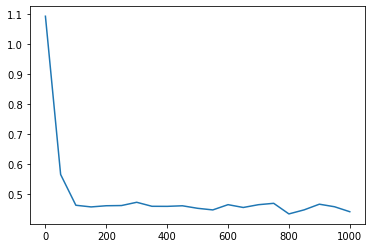

In [22]:
def one_norm(lin):
    return (lin.weight.T @ torch.tensor([1.0, -1.0])).abs().sum().item()
xs = [_[0] for _ in lip_points]
ys = [one_norm(_[1]) for _ in lip_points]
plt.plot(xs, ys)

In [ ]:
labels = mb[1].view(-1, 1)
y = torch.FloatTensor(labels.numel(), 2)
y.zero_()
y.scatter_(1, labels, 1)